In [69]:
import numpy as np
from numpy import cos, sin, tan
from numpy.linalg import inv
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300

Implementation of:

- https://harikrishnansuresh.github.io/assets/QuadcopterControlFinalVersion.pdf
- See https://harikrishnansuresh.github.io/assets/quadcopter_control_project_report.pdf for extended version

In [62]:
def rotation_matrix(phi, theta, psi):
    return np.array(
        [
            [
                cos(psi) * cos(theta),
                cos(phi) * sin(theta) * sin(phi) - sin(psi) * cos(phi),
                cos(psi) * sin(theta) * cos(phi) + sin(psi) * sin(phi),
            ],
            [
                sin(psi) * cos(theta),
                sin(psi) * sin(theta) * sin(phi) + cos(psi) * cos(phi),
                sin(psi) * sin(theta) * cos(phi) - cos(psi) * sin(phi),
            ],
            [
                -sin(theta),
                cos(theta) * sin(phi),
                cos(theta) * cos(phi),
            ],
        ]
    )

In [63]:
def body_to_inertial(phi, theta, psi):
    return np.array(
        [
            [1, sin(phi) * tan(theta), cos(phi) * tan(theta)],
            [0, cos(phi), -sin(phi)],
            [0, sin(phi) / cos(theta), cos(phi) / cos(theta)],
        ]
    )

In [151]:
m = 0.468  # mass
L = 0.225  # distance from center of mass to propeller
K = 2.980 * 10**-6  # thrust coefficient
B = 0.14 * 10 ** (-6)  # drag coefficient
g = 9.81  # gravity
Ix = 4.856 * 10**-3  # moment of inertia x
Iy = 4.856 * 10**-3  # moment of inertia y
Iz = 8.801 * 10**-3  # moment of inertia z
Ir = 3.357 * 10**-5
Ax = 0.3
Ay = 0.3
Az = 0.25
Ar = 0.2

G = np.array([0, 0, -g])  # gravity vector


def Xp(t, y, rotor_ctrl_fn):
    rotor_ctrl = rotor_ctrl_fn(t)
    X, Y, Z, phi, theta, psi, U, V, W, P, Q, R = y
    # Thrust components
    T = K * rotor_ctrl**2

    moment_body = np.array(
        [
            L * (T[3] - T[2]),
            L * (T[2] - T[0]),
            B
            * (
                -(rotor_ctrl[0] ** 2)
                + rotor_ctrl[1] ** 2
                - rotor_ctrl[2] ** 2
                + rotor_ctrl[3] ** 2
            ),
        ]
    )
    moment_drag = Ar * np.array(
        [
            P,
            Q,
            R,
        ]
    )

    phi_dot, theta_dot, psi_dot = body_to_inertial(phi, theta, psi) @ np.array(
        [P, Q, R]
    )

    # Drag force
    Fd = np.array(
        [
            Ax * U,
            Ay * V,
            Az * W,
        ]
    )
    U_dot, V_dot, W_dot = (
        1
        / m
        * (G + rotation_matrix(phi, theta, psi) @ np.array([0, 0, np.sum(T)]) - Fd)
    )

    angular_velocity = np.array([P, Q, R])
    I = np.diag([Ix, Iy, Iz])
    I_inv = inv(I)
    P_dot, Q_dot, R_dot = I_inv @ (
        moment_body
        - moment_drag
        - np.cross(angular_velocity, I @ angular_velocity)
        # Gyroscopic effect
        - Ir
        * np.cross(
            angular_velocity,
            np.array(
                [0, 0, -rotor_ctrl[0] + rotor_ctrl[1] - rotor_ctrl[2] + rotor_ctrl[3]]
            ),
        )
    )

    return np.array(
        [
            # Linear velocity
            U,
            V,
            W,
            # Angular velocity
            phi_dot,
            theta_dot,
            psi_dot,
            # Linear Acceleration
            U_dot,
            V_dot,
            W_dot,
            # Angular Acceleration
            P_dot,
            Q_dot,
            R_dot,
        ]
    )

In [172]:
tf = 10


def rotor_ctrl_fn(t):
    if t < 5:
        return np.array([2000, 300, -2000, -300])
    else:
        return np.array([1000, 1000, 1000, 1000])


res = solve_ivp(
    Xp,
    (0, tf),
    np.zeros(12),
    t_eval=np.linspace(0, tf, 300),
    args=(rotor_ctrl_fn,),
)

In [173]:
X, Y, Z = res.y[:3, :]
t = res.t

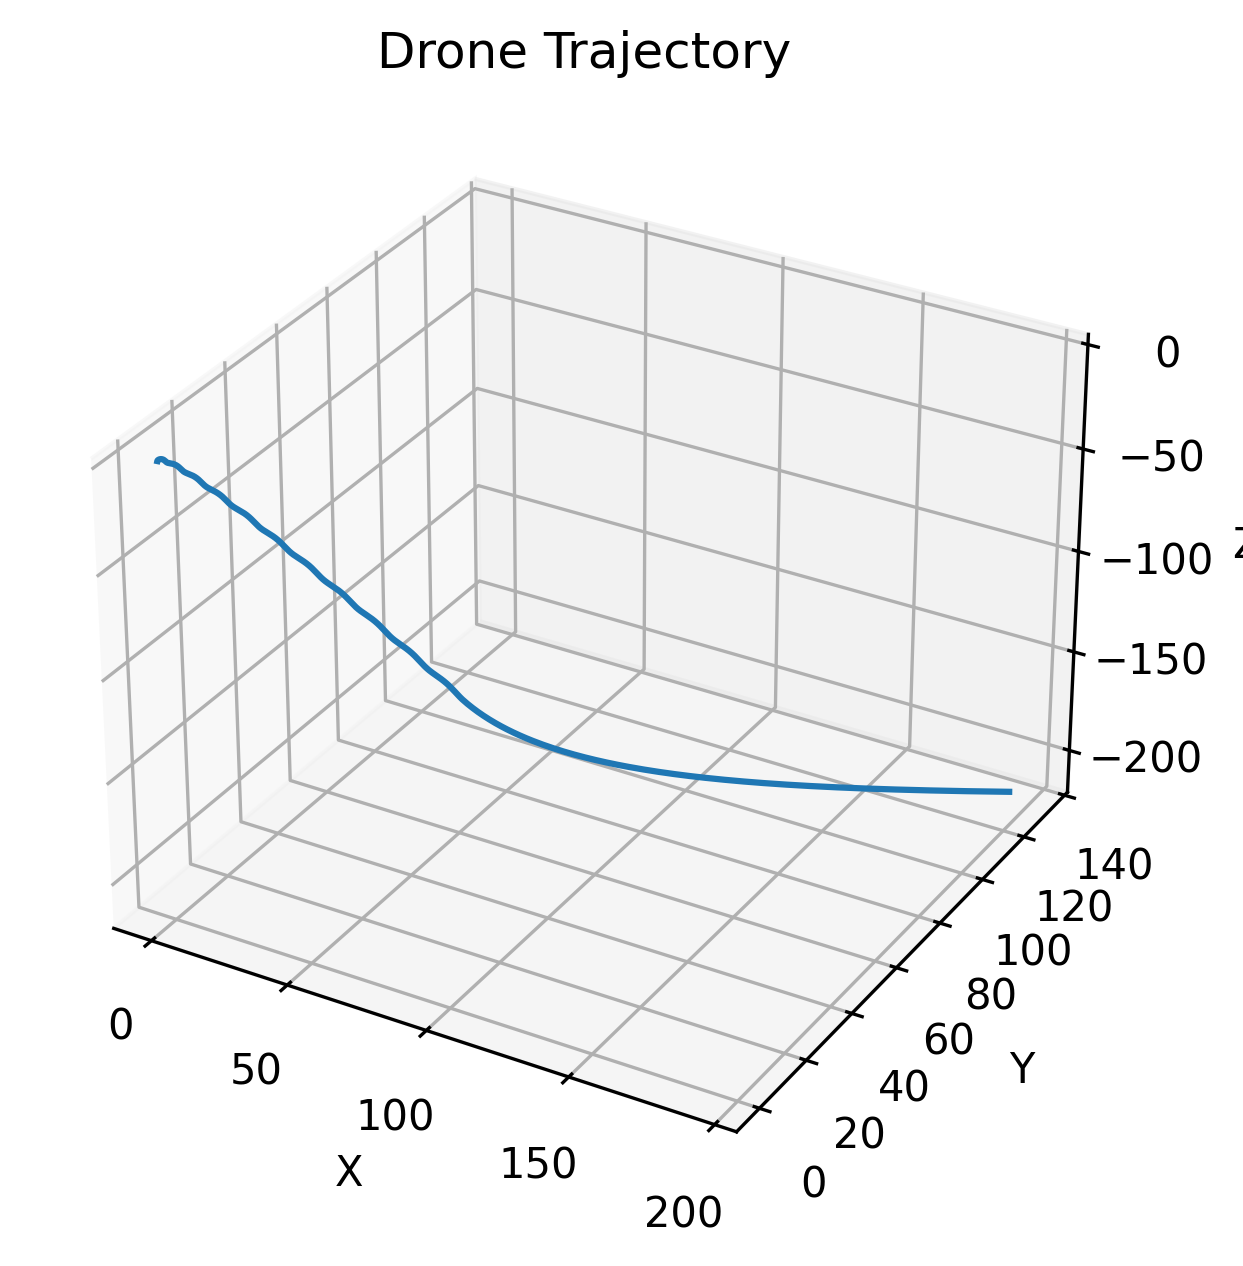

In [174]:
# Plot the trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(X, Y, Z)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Drone Trajectory")
plt.show()

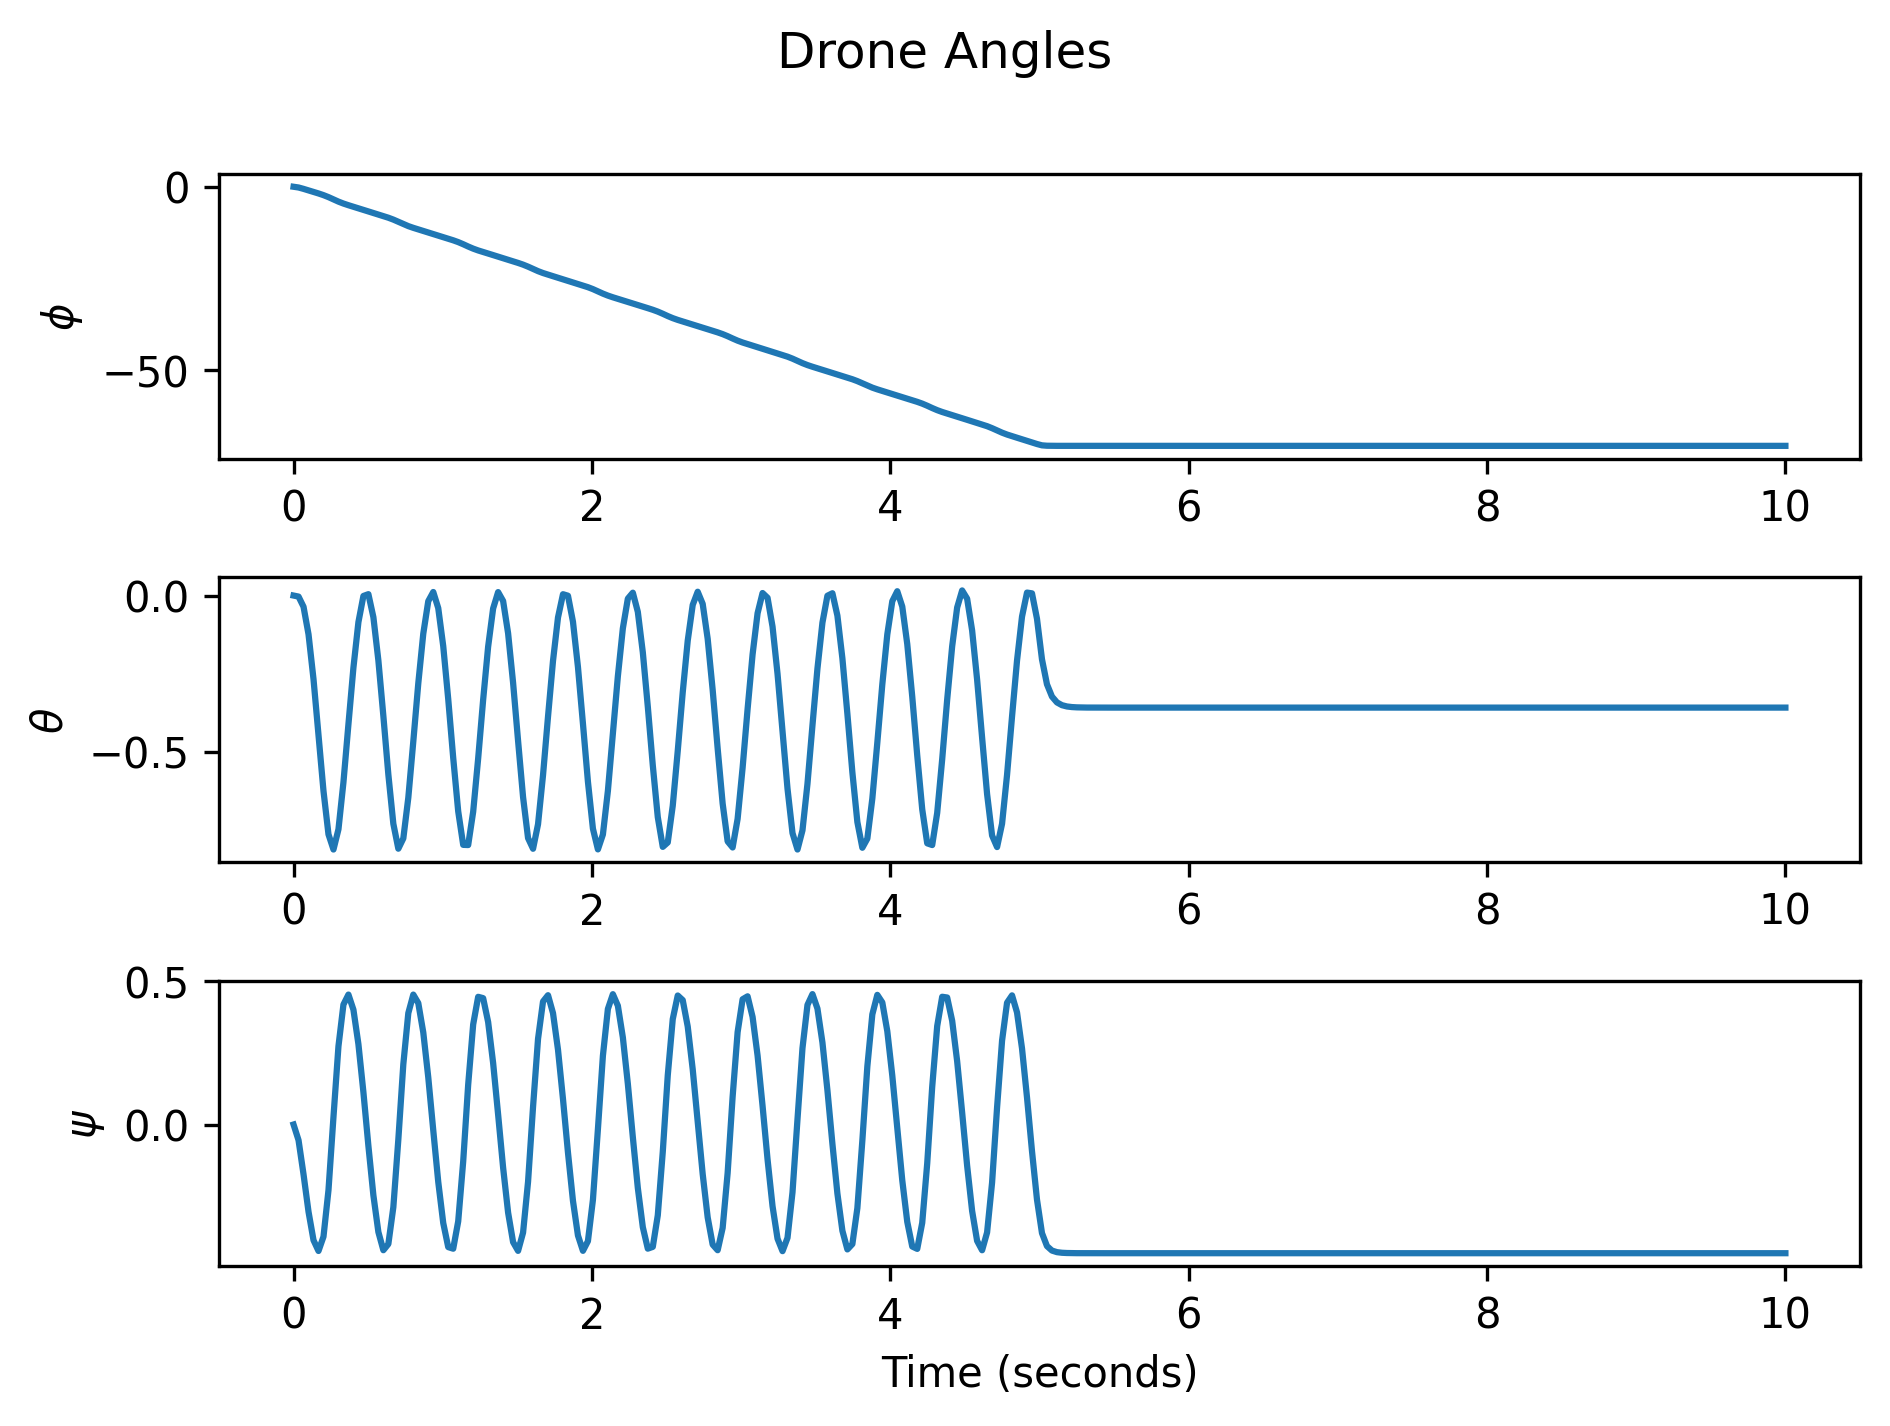

In [175]:
# Plot the angles
plt.subplot(311)
plt.plot(t, res.y[3, :])
plt.ylabel(r"$\phi$")
plt.subplot(312)
plt.plot(t, res.y[4, :])
plt.ylabel(r"$\theta$")
plt.subplot(313)
plt.plot(t, res.y[5, :])
plt.xlabel("Time (seconds)")
plt.ylabel(r"$\psi$")
plt.tight_layout()
plt.suptitle("Drone Angles")
plt.subplots_adjust(top=0.88)
plt.show()

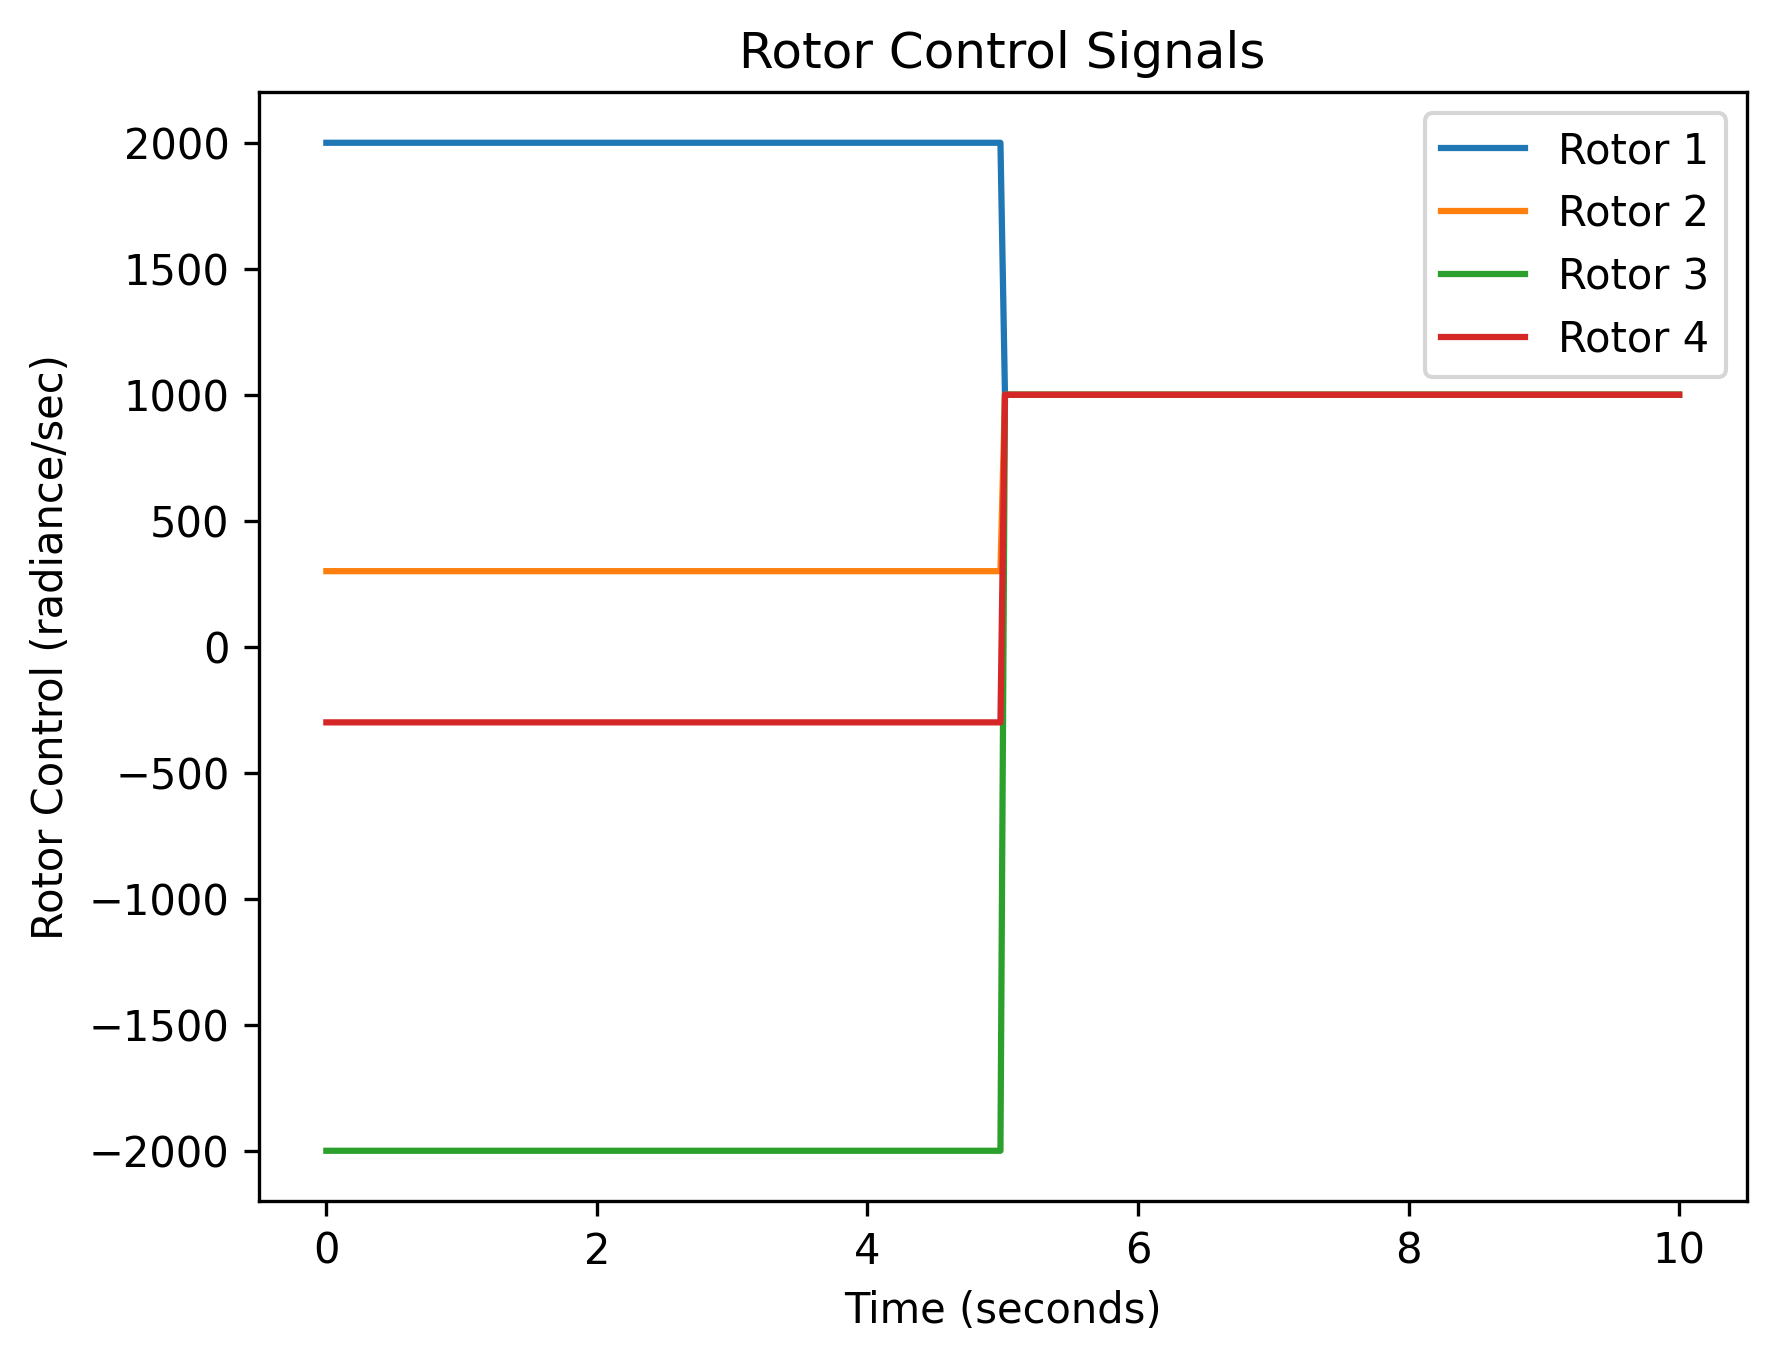

In [176]:
# Plot the rotor control
rotor_ctrl = np.array([rotor_ctrl_fn(ti) for ti in t])
plt.plot(t, rotor_ctrl[:, 0], label="Rotor 1")
plt.plot(t, rotor_ctrl[:, 1], label="Rotor 2")
plt.plot(t, rotor_ctrl[:, 2], label="Rotor 3")
plt.plot(t, rotor_ctrl[:, 3], label="Rotor 4")
plt.xlabel("Time (seconds)")
plt.ylabel("Rotor Control (radiance/sec)")
plt.legend()
plt.title("Rotor Control Signals")
plt.show()

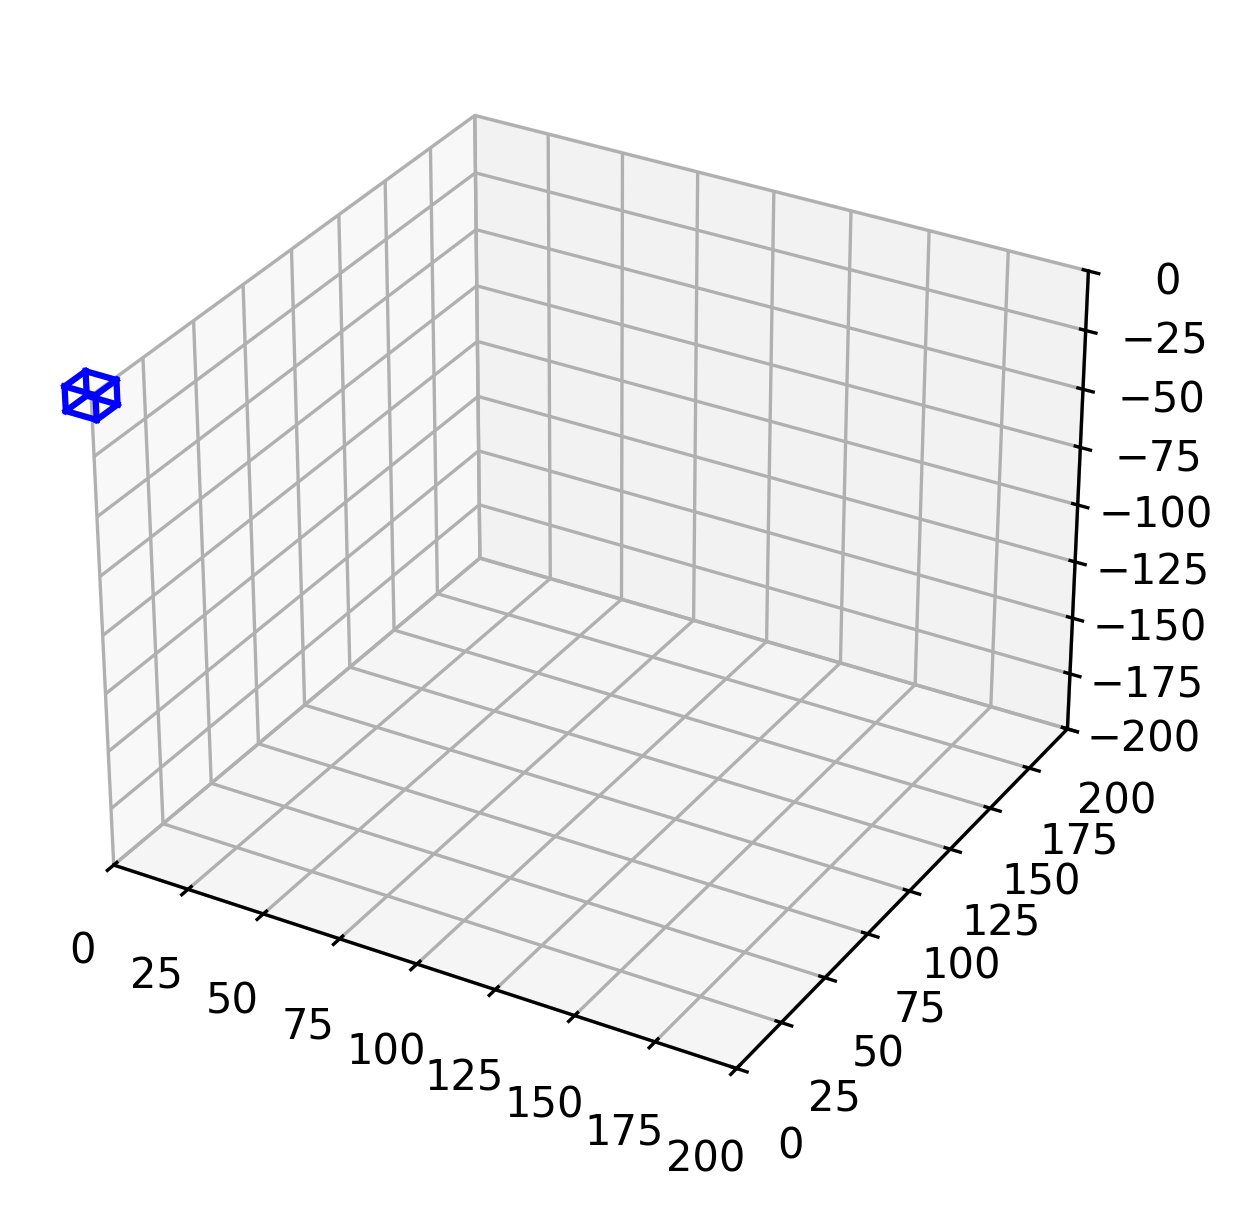

In [178]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video

# Sample data: positions (x, y, z) and angles (roll, pitch, yaw)
positions = res.y[:3, :].T  # Shape: (N, 3)
angles = res.y[3:6, :].T  # Shape: (N, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-200, 0)

# Represent the quadcopter as a rectangular prism
quad = [ax.plot([], [], [], "b-")[0] for _ in range(12)]  # 12 edges of a cube


def update(frame):
    x, y, z = positions[frame]
    roll, pitch, yaw = angles[frame]

    # Define cube vertices and apply rotations/translations
    vertices = (
        np.array(
            [
                [-1, -1, -1],
                [1, -1, -1],
                [1, 1, -1],
                [-1, 1, -1],
                [-1, -1, 1],
                [1, -1, 1],
                [1, 1, 1],
                [-1, 1, 1],
            ]
        )
        * 5
    )

    rotated = vertices @ rotation_matrix(roll, pitch, yaw) + [x, y, z]

    # Update cube edges
    edges = [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 0),
        (4, 5),
        (5, 6),
        (6, 7),
        (7, 4),
        (0, 4),
        (1, 5),
        (2, 6),
        (3, 7),
    ]
    for i, (start, end) in enumerate(edges):
        quad[i].set_data(
            [rotated[start][0], rotated[end][0]], [rotated[start][1], rotated[end][1]]
        )
        quad[i].set_3d_properties([rotated[start][2], rotated[end][2]])
    return quad


fps = 30
ani = FuncAnimation(
    fig,
    update,
    frames=len(positions),
    interval=np.ceil((1000 * tf) / (len(positions) - 1)),
)

# Save
ani.save("quadcopter_animation.mp4", writer="ffmpeg", fps=fps)
Video("quadcopter_animation.mp4")